# Collect the items - discrete actions

in order to be able to use rllib's DQN is necessary to implement a new version of the environment in which actions are discrete instead of continuous. 

Still the agents' goal is the same as before: collecting all the items in the environment minimizing the number of steps by collaborating together. 

## Preparing the notebook

### import and utils

In [1]:
from utils.vectors import Vector2D
from utils.canvas import CanvasWithBorders
from utils.algo_utils import (save_algo, load_algo)
from utils.metrics import (save_dict_as_json, load_json_as_dict, plot_metrics, compare_metrics)
from utils.simulations import (simulate_episode, simulate_random_episode, dqn_result_format)

from ray.rllib.env.multi_agent_env import MultiAgentEnv
from gymnasium.spaces import Discrete, Box, Dict, Tuple, MultiDiscrete
from gymnasium.spaces.utils import flatten, flatten_space
from IPython.display import clear_output
from ipycanvas import Canvas, hold_canvas
from typing import Set
import random as rnd
import numpy as np
import math

### defining the environment

In [2]:
class EnvironmentConfiguration: 
    def __init__(self, n_agents, n_targets, agent_range, movement_granularity, speed_granularity, spawn_area=100, visible_nbrs=1, visible_targets=1, max_steps=None, cache_size=1):
        # parameters that shouldn't affect the agents' behaviour
        self.n_agents = n_agents
        self.n_targets = n_targets
        self.spawn_area = spawn_area
        self.max_steps = max_steps
        # parameters that affect the agents' behavious
        self.agent_range = agent_range
        # parameters that affect the observation space
        self.visible_nbrs = visible_nbrs
        self.visible_targets = visible_targets
        self.cache_size = cache_size
        # parameters that affect the action space
        self.movement_granularity = movement_granularity
        self.speed_granularity = speed_granularity

    def __deepcopy__(self, memo):
        return EnvironmentConfiguration(
            self.n_agents, 
            self.n_targets, 
            self.agent_range, 
            self.movement_granularity, 
            self.speed_granularity, 
            self.spawn_area, 
            self.visible_nbrs, 
            self.visible_targets, 
            self.max_steps, 
            self.cache_size
        )

In [3]:
class CollectTheItems(MultiAgentEnv):
    canvas = None
    CANVAS_WIDTH, CANVAS_HEIGHT = 300.0, 300.0

    def __init__(self, config: EnvironmentConfiguration):
        assert config.n_agents > config.visible_nbrs
        assert config.movement_granularity % 2 == 1

        self.n_agents = config.n_agents
        self.n_targets = config.n_targets
        self.spawn_area = config.spawn_area
        self.max_steps = config.max_steps
        self.agent_range = config.agent_range
        self.visible_nbrs = config.visible_nbrs
        self.visible_targets = config.visible_targets
        self.cache_size = config.cache_size
        self.movement_granularity = config.movement_granularity
        self.speed_granularity = config.speed_granularity

        self.agents_ids = ['agent-' + str(i) for i in range(self.n_agents)]
        self.observation_space = self.observation_space('agent-0')
        self.action_space = self.action_space('agent-0')

    def unflatten_observation_space(self, agent):
        direction = Box(low=-1, high=1, shape=(2,1), dtype=np.float32)
        distance = Box(low=-np.inf, high=np.inf, shape=(1,1), dtype=np.float32)

        nbrs = Dict({f"nbr-{i}": Dict({'direction': direction, 'distance': distance}) for i in range(self.visible_nbrs)})
        targets = Dict({f"target-{i}": Dict({'direction': direction, 'distance': distance}) for i in range(self.visible_targets)})

        time_t_obs = Dict({"nbrs": nbrs, "targets": targets})

        return Dict({f"t[-{t}]": time_t_obs for t in range(0, self.cache_size)})

    def observation_space(self, agent):
        return flatten_space(self.unflatten_observation_space(agent))

    def __continuous_action(self, discrete_action):
        action_tuple = (discrete_action // (self.movement_granularity*self.speed_granularity), 
                        (discrete_action % (self.movement_granularity*self.speed_granularity)) // (self.speed_granularity), 
                        discrete_action % self.speed_granularity)

        return [(2*(action_tuple[0] / (self.movement_granularity-1))-1),
                (2*(action_tuple[1] / (self.movement_granularity-1))-1),
                (action_tuple[2]) / float(self.speed_granularity-1)]

    def action_space(self, agent):
        """
        direction_x = Discrete(self.movement_granularity)#Box(low=-1.0, high=1.0, shape=(2,1), dtype=np.float32)
        direction_y = Discrete(self.movement_granularity)
        speed = Discrete(self.speed_granularity)#Box(0.0, 1.0, dtype=np.float32)
        return Tuple([direction_x, direction_y, speed])
        """
        return Discrete(self.movement_granularity * self.movement_granularity * self.speed_granularity)
    
    def __get_time_t_observation(self, agent):
        nbrs_distance_vectors = [Vector2D.distance_vector(self.agents_pos[agent], self.agents_pos[nbr])  
                            for nbr in self.__get_n_closest_neighbours(agent, self.visible_nbrs)]

        targets_distance_vectors = [Vector2D.distance_vector(self.agents_pos[agent], self.targets_pos[target])  
                            for target in self.__get_n_closest_targets(agent, self.visible_targets)]

        nbrs = {
            f"nbr-{i}": {
                "direction": Vector2D.unit_vector(nbrs_distance_vectors[i]).to_np_array(),
                "distance": np.log(1 + Vector2D.norm(nbrs_distance_vectors[i])) #1 - np.exp(-alpha * x)
            }
            for i in range(len(nbrs_distance_vectors))
        }
    
        targets = {
            f"target-{i}": {
                "direction": Vector2D.unit_vector(targets_distance_vectors[i]).to_np_array(),
                "distance": np.log(1 + Vector2D.norm(targets_distance_vectors[i])) #1 - np.exp(-alpha * x)
            }
            for i in range(len(targets_distance_vectors))
        }
        
        for i in range(len(targets_distance_vectors), self.visible_targets):
            targets[f"target-{i}"] = {
                "direction": np.array([0,0], dtype=np.int32),
                "distance": -1 #1 - np.exp(-alpha * x)
            }

        obs = {
            "nbrs": nbrs,
            "targets": targets
        }

        return obs

    def __get_observation(self, agent):
        if len(self.observation_cache[agent]) == 0:
            self.observation_cache[agent] = [self.__get_time_t_observation(agent)]*self.cache_size
        else:
            self.observation_cache[agent] = [self.__get_time_t_observation(agent)] + self.observation_cache[agent]
            self.observation_cache[agent].pop()

        obs = {
            f"t[-{t}]": self.observation_cache[agent][t]
            for t in range(0, self.cache_size)
        }

        return flatten(self.unflatten_observation_space(agent), obs)

    def rgb_to_hex(self, r, g, b):
        return f'#{r:02x}{g:02x}{b:02x}'

    def __get_local_reward(self, agent, action):
        # reward_1: small bonus if the agent collects an item
        reward_1 = +5 if agent in self.collectors else 0

        # reward_2: malus if the agent collides with another agent 
        reward_2= sum([-2 if Vector2D.distance(self.agents_pos[agent], self.agents_pos[nbr]) < self.agent_range*2 else 0 for nbr in self.__get_other_agents(agent)])

        # reward_3: -1 at each step
        reward_3 = -1

        # reward_4: positive reward if the agent moves toward the closest targets, negative otherwise
        distance_diff = ([Vector2D.distance(self.agent_old_pos[agent], self.targets_pos[target]) -
                    Vector2D.distance(self.agents_pos[agent], self.targets_pos[target])
            for target in self.closest_targets[agent]])
        
        reward_4 = max(distance_diff) if len(distance_diff) > 0 else 0

        # reward_5: positive reward when increasing the distance from the neighbours
        distance_diff = [Vector2D.distance(self.agents_pos[agent], self.agents_pos[nbr]) -
                         Vector2D.distance(self.agent_old_pos[agent], self.agent_old_pos[nbr])
                         for nbr in self.__get_n_closest_neighbours(agent, self.visible_nbrs)]
        
        reward_5 = np.mean(distance_diff)/2.0 if len(distance_diff) > 0 else 0

        # reward_6: positive reward if an old visible target has been collected
        old_visible_target_collected = [1 if not(target in self.targets_pos.keys()) else 0 for target in self.old_visible_targets[agent]]
        self.old_visible_targets[agent] = self.__get_n_closest_targets(agent, self.visible_targets)

        reward_6 = sum(old_visible_target_collected) * 100

        self.info[agent] = {"info": {f"r2: {reward_2}, r3: {reward_3}, r4: {reward_4} , r5: {reward_5}, r6: {reward_6}"}}
        return  reward_3 + reward_4*3 + reward_2 + reward_5 + reward_6

    def __get_global_reward(self):
        return 0#self.global_reward * 100
    
    def __get_other_agents(self, agent):
        return [other for other in self.agents_ids if other != agent]

    def __get_n_closest_neighbours(self, agent, n=1):
        distances = {other: Vector2D.distance(self.agents_pos[agent], self.agents_pos[other]) for other in self.__get_other_agents(agent)}
        return [neighbour[0] for neighbour in sorted(list(distances.items()), key=lambda d: d[1])[:n]]
        # return {neighbour[0]: neighbour[1] for neighbour in sorted(list(dst.items()), key=lambda d: d[0])[:n]}

    def __get_n_closest_targets(self, agent, n=1):
        n = min(n, len(self.targets_pos.keys()))
        distances = {target: Vector2D.distance(self.agents_pos[agent], pos) for target, pos in self.targets_pos.items()}
        self.closest_targets[agent] = [target[0] for target in sorted(list(distances.items()), key=lambda d: d[1])[:n]]
        return self.closest_targets[agent]

    def __update_agent_position(self, agent, action):
        unit_movement = Vector2D(action[0], action[1])
        self.agent_old_pos[agent] = self.agents_pos[agent]
        self.agents_pos[agent] = Vector2D.sum(self.agents_pos[agent], Vector2D.mul(unit_movement, action[2]))

    def __collect_items(self):
        self.collectors = []
        uncollected_targets = {}
        for target, target_pos in self.targets_pos.items():
            collected = False
            for agent in self.agents_pos.values():
                if Vector2D.distance(target_pos, agent) < self.agent_range:
                    collected = True
                    self.collectors.append(agent)
            if not collected:
                uncollected_targets[target] = target_pos
        self.targets_pos = uncollected_targets

    def __collect_items_and_compute_global_reward(self):
        old_uncollected_items = len(self.targets_pos.keys())
        self.__collect_items()
        updated_uncollected_items = len(self.targets_pos.keys())
        self.global_reward = old_uncollected_items - updated_uncollected_items

    def reset(self, seed=None, options=None):
        self.steps = 0
        self.agents_pos = {agent: Vector2D.get_random_point(max_x=self.spawn_area, max_y=self.spawn_area) for agent in self.agents_ids}
        self.agent_old_pos = dict(self.agents_pos)
        self.targets_pos = {f"target-{i}": Vector2D.get_random_point(max_x=self.spawn_area, max_y=self.spawn_area) for i in range(self.n_targets)}
        self.collectors = []
        self.closest_targets = {}
        self.old_visible_targets = {agent: self.__get_n_closest_targets(agent, self.visible_targets) for agent in self.agents_ids}
        self.info = {}
        self.observation_cache = {agent: [] for agent in self.agents_ids}
        return {agent: self.__get_observation(agent) for agent in self.agents_ids}, {}
     
    def step(self, actions):
        self.steps += 1
        observations, rewards, terminated, truncated, infos = {}, {}, {}, {}, {}

        for agent, action in actions.items():
            self.__update_agent_position(agent, self.__continuous_action(action))

        self.__collect_items_and_compute_global_reward()

        for agent, action in actions.items():
            observations[agent] = self.__get_observation(agent)
            rewards[agent] = self.__get_local_reward(agent, self.__continuous_action(action)) + self.__get_global_reward()
            terminated[agent] = False
            truncated[agent] = False
            infos[agent] = self.info[agent]

        truncated['__all__'] = False
        if len(self.targets_pos.keys()) == 0:
            terminated['__all__'] = True
        elif self.max_steps != None and self.steps == self.max_steps:
            terminated['__all__'] = True
        else:
            terminated['__all__'] = False

        return observations, rewards, terminated, truncated, infos
     
    def rgb_to_hex(self, r, g, b):
        return f'#{r:02x}{g:02x}{b:02x}'

    def render(self):
        pass

    def get_agent_ids(self):
       return self.agents


class RenderableCollectTheItems(CollectTheItems):
    def __init__(self, config: EnvironmentConfiguration):
        super().__init__(config)
        self.agent_colors = {agent: self.rgb_to_hex(rnd.randint(0, 255), rnd.randint(0, 255), rnd.randint(0, 255)) for agent in self.agents_ids}

        self.unit = self.CANVAS_WIDTH/float(self.spawn_area)
        self.render_size_agent = max(self.unit,1)
        self.render_size_agent_range = self.unit*self.agent_range

        self.reset()

    def __position_in_frame(self, position_in_env):
        return [((self.spawn_area-position_in_env[0])/self.spawn_area)*self.CANVAS_WIDTH,
                        ((self.spawn_area-position_in_env[1])/self.spawn_area)*self.CANVAS_HEIGHT,]

    def render(self):
        with hold_canvas():
            if self.canvas == None:
                self.canvas = CanvasWithBorders(width=self.CANVAS_WIDTH, height=self.CANVAS_HEIGHT)
                display(self.canvas)

            self.canvas.clear()

            self.canvas.fill_style = "red"
            for target in self.targets_pos.values():
                self.canvas.draw_circle(pos=self.__position_in_frame(target.to_np_array()), 
                                        radius=1, 
                                        fill_color="red")

            for agent in self.agents_ids:
                self.canvas.draw_circle(pos=self.__position_in_frame(self.agents_pos[agent].to_np_array()), 
                                        radius=self.render_size_agent/2.0, 
                                        fill_color=self.agent_colors[agent],
                                        border_color="black")

                self.canvas.draw_circle(pos=self.__position_in_frame(self.agents_pos[agent].to_np_array()), 
                                        radius=self.render_size_agent_range, 
                                        border_color="red")

### environment demonstration

In [4]:
env_config = EnvironmentConfiguration(
    n_agents = 4,
    n_targets = 2,
    spawn_area = 100,
    max_steps=300,
    agent_range = 5,
    visible_nbrs = 3,
    visible_targets = 3,
    cache_size=3,
    movement_granularity=5,
    speed_granularity=5)

env = RenderableCollectTheItems(env_config)

print("action space: ", env.action_space)
print("observation space: ", env.unflatten_observation_space("agent-0"))

simulate_random_episode(env, 100, sleep_between_frames=0.03, print_info=False)

action space:  Discrete(125)
observation space:  Dict('t[-0]': Dict('nbrs': Dict('nbr-0': Dict('direction': Box(-1.0, 1.0, (2, 1), float32), 'distance': Box(-inf, inf, (1, 1), float32)), 'nbr-1': Dict('direction': Box(-1.0, 1.0, (2, 1), float32), 'distance': Box(-inf, inf, (1, 1), float32)), 'nbr-2': Dict('direction': Box(-1.0, 1.0, (2, 1), float32), 'distance': Box(-inf, inf, (1, 1), float32))), 'targets': Dict('target-0': Dict('direction': Box(-1.0, 1.0, (2, 1), float32), 'distance': Box(-inf, inf, (1, 1), float32)), 'target-1': Dict('direction': Box(-1.0, 1.0, (2, 1), float32), 'distance': Box(-inf, inf, (1, 1), float32)), 'target-2': Dict('direction': Box(-1.0, 1.0, (2, 1), float32), 'distance': Box(-inf, inf, (1, 1), float32)))), 't[-1]': Dict('nbrs': Dict('nbr-0': Dict('direction': Box(-1.0, 1.0, (2, 1), float32), 'distance': Box(-inf, inf, (1, 1), float32)), 'nbr-1': Dict('direction': Box(-1.0, 1.0, (2, 1), float32), 'distance': Box(-inf, inf, (1, 1), float32)), 'nbr-2': Dict('d

CanvasWithBorders(height=300, width=300)

## Training

### preparing the environment

In [5]:
from ray.tune.registry import register_env

env_config = EnvironmentConfiguration(
    n_agents = 4,
    n_targets = 10,
    spawn_area = 200,
    max_steps=300,
    agent_range = 3,
    visible_nbrs = 3,
    visible_targets = 3,
    cache_size=3,
    movement_granularity=5,
    speed_granularity=5)

register_env("collect_the_items?algo=DQN&method=CTDE", lambda _: RenderableCollectTheItems(env_config))

### restart ray

In [ ]:
import ray
ray.shutdown()

### DQN

In [7]:
from ray.rllib.algorithms.dqn.dqn import DQNConfig

training_iterations = 50

algo = (DQNConfig()
        .training(
            gamma=0.95,
            lr=0.001,
            train_batch_size=32,
            n_step=1,
            target_network_update_freq=500,
            double_q=True,
            dueling=True)
        .env_runners(num_env_runners=1)
        .resources(num_gpus=0)  
        .environment("collect_the_items?algo=DQN&method=CTDE")
    ).build()

clear_output()

metrics = {
    "mean_episode_length": [],
    "mean_reward": []
}

out = ""
for i in range(training_iterations):
    result = algo.train()
    clear_output()
    out += dqn_result_format(result) + "\n"
    print(out)
    metrics["mean_episode_length"].append(result['sampler_results']['episode_len_mean'])
    metrics["mean_reward"].append(result['sampler_results']['episode_reward_mean'])
    simulate_episode(RenderableCollectTheItems(env_config), algo, 500, sleep_between_frames=0.01, print_info=True)

iteration [1] => episode_reward_mean: -10887.082882299715, episode_len_mean: 300.0
iteration [2] => episode_reward_mean: -10709.24970189067, episode_len_mean: 300.0
iteration [3] => episode_reward_mean: -10264.532208940449, episode_len_mean: 300.0
iteration [4] => episode_reward_mean: -10051.871516573021, episode_len_mean: 300.0
iteration [5] => episode_reward_mean: -9716.788689889669, episode_len_mean: 300.0
iteration [6] => episode_reward_mean: -9277.956190889676, episode_len_mean: 300.0
iteration [7] => episode_reward_mean: -8986.700231180392, episode_len_mean: 299.3478260869565
iteration [8] => episode_reward_mean: -8394.057941627967, episode_len_mean: 292.5925925925926
iteration [9] => episode_reward_mean: -7822.729359931818, episode_len_mean: 284.19354838709677
iteration [10] => episode_reward_mean: -7218.847308073281, episode_len_mean: 274.8888888888889
iteration [11] => episode_reward_mean: -6695.584341532721, episode_len_mean: 264.5853658536585
iteration [12] => episode_reward

CanvasWithBorders(height=300, width=300)

info:  {'agent-0': {'info': {'r2: 0, r3: -10, r4: 1.4127518487812 , r5: -0.05540950838975552, r6: 0'}}, 'agent-1': {'info': {'r2: 0, r3: -10, r4: 1.016764007945234 , r5: -0.4780187374244124, r6: 0'}}, 'agent-2': {'info': {'r2: 0, r3: -10, r4: 1.403928371837651 , r5: -0.5105477175499011, r6: 0'}}, 'agent-3': {'info': {'r2: 0, r3: -10, r4: 1.1560285447406855 , r5: -0.8105705391960664, r6: 0'}}}
info:  {'agent-0': {'info': {'r2: 0, r3: -10, r4: 1.4124447002447962 , r5: -0.03904361795457589, r6: 0'}}, 'agent-1': {'info': {'r2: 0, r3: -10, r4: 1.005951537600005 , r5: -0.47301010239861885, r6: 0'}}, 'agent-2': {'info': {'r2: 0, r3: -10, r4: 1.4025739429500632 , r5: -0.5063240497975009, r6: 0'}}, 'agent-3': {'info': {'r2: 0, r3: -10, r4: 1.1377659372101334 , r5: -0.7857963860739154, r6: 0'}}}
info:  {'agent-0': {'info': {'r2: 0, r3: -10, r4: 1.412029468281414 , r5: 0.012081561191408241, r6: 0'}}, 'agent-1': {'info': {'r2: 0, r3: -10, r4: 1.1834700189250071 , r5: -0.3565836759204248, r6: 0'}},

2024-07-05 13:28:45,736	ERROR actor_manager.py:519 -- Ray error, taking actor 1 out of service. The actor 7823c3ca1c98cfbfefdf9ae101000000 is unavailable: The actor is temporarily unavailable: IOError: The actor is restarting.. The task may or maynot have been executed on the actor.
2024-07-05 13:28:45,737	WARNING rollout_ops.py:112 -- No samples returned from remote workers. If you have a slow environment or model, consider increasing the `sample_timeout_s` or decreasing the `rollout_fragment_length` in `AlgorithmConfig.env_runners().
2024-07-05 13:28:47,737	WARNING rollout_ops.py:112 -- No samples returned from remote workers. If you have a slow environment or model, consider increasing the `sample_timeout_s` or decreasing the `rollout_fragment_length` in `AlgorithmConfig.env_runners().
2024-07-05 13:28:49,738	WARNING rollout_ops.py:112 -- No samples returned from remote workers. If you have a slow environment or model, consider increasing the `sample_timeout_s` or decreasing the `ro

KeyboardInterrupt: 

### show results

#### plot metrics

'\nfig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 5))\n\nax1.plot(metrics["mean_episode_length"], linestyle=\'-\', color=\'r\', label=\'Mean episode length\')\nax2.plot(metrics["mean_reward"], linestyle=\'-\', color=\'y\', label=\'Mean reward\')\n'

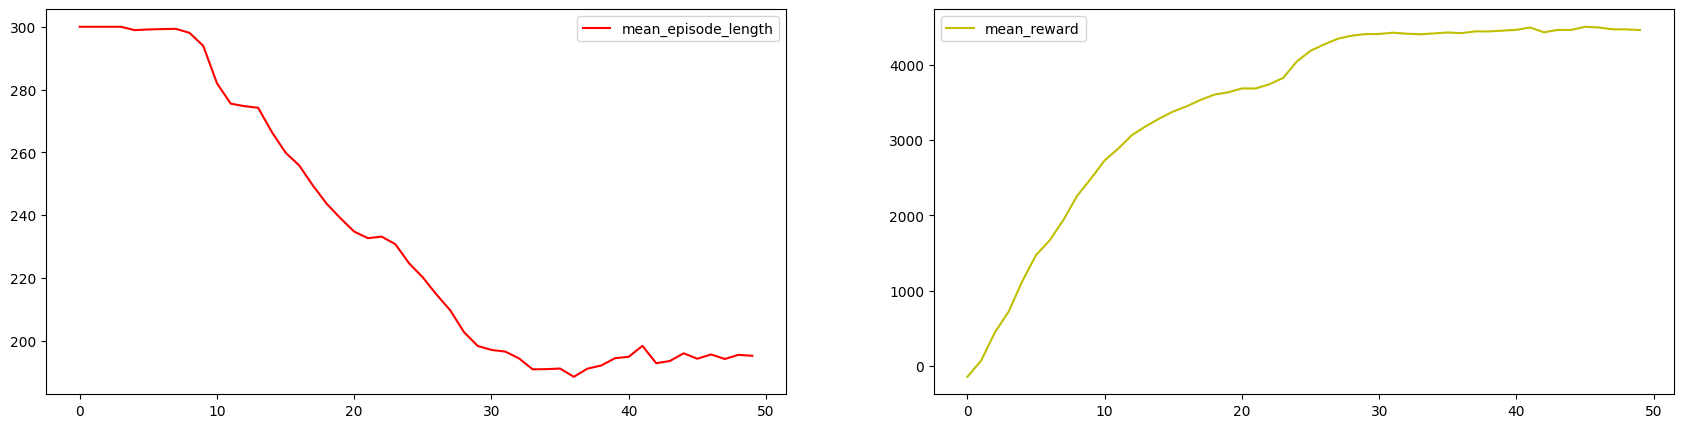

In [88]:
from matplotlib import pyplot as plt

plot_metrics(metrics, "mean_episode_length", "mean_reward")
"""
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 5))

ax1.plot(metrics["mean_episode_length"], linestyle='-', color='r', label='Mean episode length')
ax2.plot(metrics["mean_reward"], linestyle='-', color='y', label='Mean reward')
"""

#### compare metrics

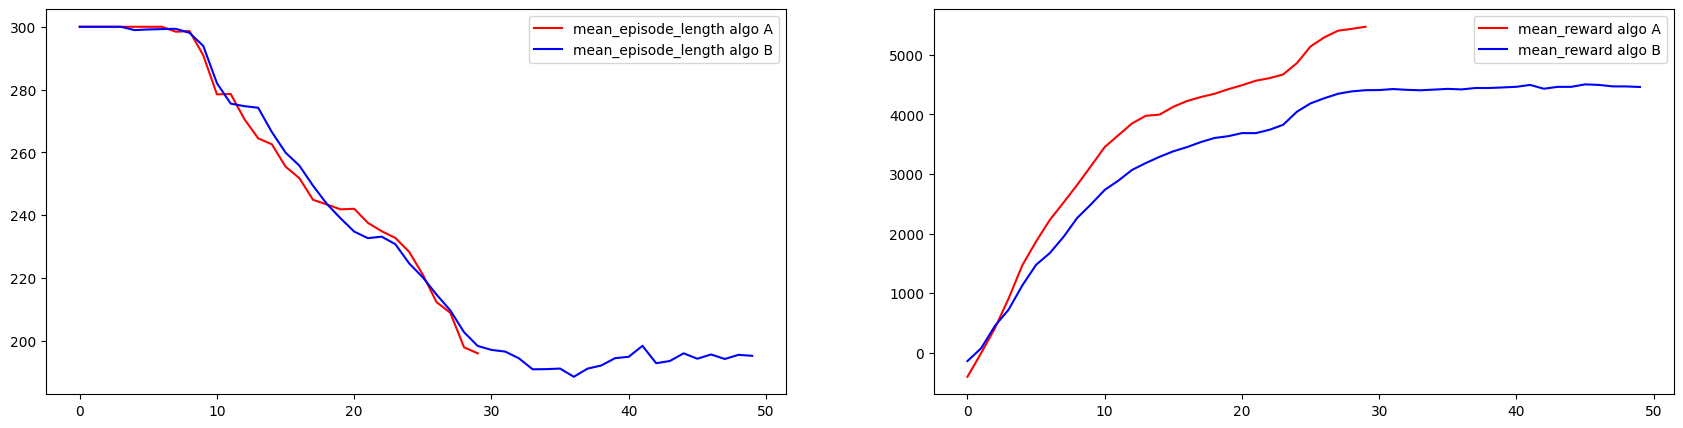

In [92]:
algo_a = "collect_the_items?algo=DQN&method=CTDE_v1" 
algo_b = "collect_the_items?algo=DQN&method=CTDE_v3"
compare_metrics(load_json_as_dict(f"metrics/{algo_a}"), load_json_as_dict(f"metrics/{algo_b}"), "mean_episode_length", "mean_reward")

## Save and load

In [89]:
algo_name = "collect_the_items?algo=DQN&method=CTDE_v3"

In [91]:
save_algo(algo, algo_name)
save_dict_as_json(metrics, f"metrics/{algo_name}")

An Algorithm checkpoint has been created inside directory: 'TrainingResult(checkpoint=Checkpoint(filesystem=local, path=/mnt/c/Users/nicol/Desktop/Università/tesi/thesis-MARL_in_Aggregate_Computing/CTDE/algos/collect_the_items?algo=DQN&method=CTDE_v3), metrics={'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'grad_gnorm': 1.865592360496521, 'mean_q': 92.03594207763672, 'min_q': 43.35439682006836, 'max_q': 204.19818115234375, 'cur_lr': 0.001}, 'td_error': array([-3.5242767e+00,  2.2293854e-01,  2.5013275e+00, -7.3225403e-01,
        5.6076050e-02,  6.8303680e-01, -4.1835251e+00, -1.9440117e+00,
       -2.3848495e+00,  2.8144836e+00,  2.6144562e+00,  4.5616150e-01,
       -1.3239517e+00, -5.1694565e+00, -9.8011566e+01, -2.0692368e+00,
       -2.0356445e+00,  1.9123001e+00,  9.4968414e-01,  3.9274673e+00,
       -1.0207809e+02,  3.2845192e+00, -2.5561218e+00,  8.3435059e-01,
        8.5964966e-01, -4.6836044e+0

In [10]:
algo = load_algo(algo_name)
metrics = load_json_as_dict(f"metrics/{algo_name}")

2024-07-05 09:19:54,247	WARNING deprecation.py:50 -- DeprecationWarning: `WorkerSet(num_workers=... OR local_worker=...)` has been deprecated. Use `EnvRunnerGroup(num_env_runners=... AND local_env_runner=...)` instead. This will raise an error in the future!
2024-07-05 09:20:02,415	WARNING util.py:61 -- Install gputil for GPU system monitoring.


## Simulation

In [50]:
new_config = env_config.__deepcopy__(None)
new_config.spawn_area = 200
new_config.n_targets = 20
env = RenderableCollectTheItems(new_config)
simulate_episode(env, algo, steps=500, sleep_between_frames=0.01)

CanvasWithBorders(height=300, width=300)